In [1]:
import numpy as np
import pandas as pd
import json
import datetime
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

In [2]:
yt_df = pd.read_csv("./US_youtube_trending_data.csv")

In [3]:
# Preprocessing
def clean_trending_date(date):
    y,m,d = date.split('T')[0].split('-')
    return datetime.date(int(y), int(m), int(d))

def clean_publish_time(time):
    y,m,d = time.split('T')[0].split('-')
    return datetime.date(int(y), int(m), int(d))

yt_df['trending_date'] = yt_df['trending_date'].apply(clean_trending_date)
yt_df['publishedAt'] = yt_df['publishedAt'].apply(clean_publish_time)

In [147]:
'''
Engagement Rate: Engagement rate as the sum of likes, dislikes, and comments divided by the total views. This metric provides an overall sense of how actively the community is interacting with the video.

Like-to-Dislike Ratio: Ratio of likes to dislikes. A higher ratio indicates that the community generally has a positive sentiment towards the video.

Comment-to-View Ratio: Ratio of comments to views. This can help identify videos that generate more discussion and engagement within the community.

Likes per Comment: Average number of likes per comment. A higher value suggests that the community is showing appreciation for the content through likes.

Dislikes per Comment: Average number of dislikes per comment. This can provide insights into the level of criticism or disagreement within the community.

Likes per Day: Average number of likes the video receives per day since its publication. This can indicate how consistent engagement has been over time.

Comments per Day: Average number of comments the video receives per day since its publication. This can indicate ongoing community interaction.

View Velocity: Rate of increase in views over time since the video's publication. Videos with a higher view velocity might be gaining traction and could trend further.
'''

# Calculate engagement_rate, like_dislike_ratio, comment_view_ratio, dislikes_per_comment
yt_df['engagement_rate'] = (yt_df['likes'] + yt_df['dislikes'] + yt_df['comment_count']) / (yt_df['view_count'] + 1e-6)
yt_df['like_dislike_ratio'] = yt_df['likes'] / (yt_df['dislikes'] + 1e-6)
yt_df['comment_view_ratio'] = yt_df['comment_count'] / (yt_df['view_count'] + 1e-6)
yt_df['dislikes_per_comment'] = yt_df['dislikes'] / (yt_df['comment_count'] + 1e-6)

# Calculate days_since_publication, likes_per_day, comments_per_day, view_velocity
yt_df['trending_date'] = pd.to_datetime(yt_df['trending_date'], format='%Y-%m-%d')
yt_df['days_since_publication'] = (yt_df['trending_date'] - pd.to_datetime(yt_df['publishedAt'])).dt.days
yt_df['likes_per_day'] = yt_df['likes'] / (yt_df['days_since_publication'] + 1e-6)
yt_df['comments_per_day'] = yt_df['comment_count'] / (yt_df['days_since_publication'] + 1e-6)
yt_df['view_velocity'] = np.log(yt_df['view_count'] + 1) / (yt_df['days_since_publication'] + 1)

yt_df.head(n=2)

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,...,ratings_disabled,description,engagement_rate,like_dislike_ratio,comment_view_ratio,dislikes_per_comment,days_since_publication,likes_per_day,comments_per_day,view_velocity
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,...,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...,0.130777,26.798975,0.023315,0.165803,1,156907.843092,35312.964687,7.115336
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,...,False,"While running her own modding shop, Ramya Pare...",0.069733,52.519327,0.006948,0.168832,1,146738.853261,16548.983451,7.341660


In [148]:
# Replace missing values with the median value
median_dislikes_per_comment = yt_df['dislikes_per_comment'].median()

# Fill missing values with the median
yt_df['dislikes_per_comment'] = yt_df['dislikes_per_comment'].fillna(median_dislikes_per_comment)

# Calculate the median of the 'comments_per_day' column
median_comments_per_day = yt_df['comments_per_day'].median()

# Fill missing values with the median
yt_df['comments_per_day'] = yt_df['comments_per_day'].fillna(median_comments_per_day)

# Calculate the median of the 'view_velocity' column
median_view_velocity = yt_df['view_velocity'].median()

# Fill missing values with the median
yt_df['view_velocity'] = yt_df['view_velocity'].fillna(median_view_velocity)

In [154]:
# Convert 'publishedAt' column to Timestamp objects
yt_df['publishedAt'] = pd.to_datetime(yt_df['publishedAt'])

# Convert datetime.date objects to Timestamp objects
start_date = pd.Timestamp('2020-01-01')
mid_date = pd.Timestamp('2023-01-01')
end_date = pd.Timestamp('2024-01-01')

# Separate data based on publishedAt time
train_data = yt_df[(yt_df['publishedAt'] >= start_date) & (yt_df['publishedAt'] < mid_date)]
test_data = yt_df[(yt_df['publishedAt'] >= mid_date)]
print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)

Training data shape: (176203, 24)
Testing data shape: (92384, 24)


In [155]:
features = ['view_count', 'likes', 'dislikes', 'comment_count', 'engagement_rate', 'like_dislike_ratio', 
            'comment_view_ratio', 'dislikes_per_comment', 'days_since_publication', 'likes_per_day', 
            'comments_per_day']

# Split the data into features and target variable
X_train = train_data[features]
y_train = train_data['view_velocity']

X_test = test_data[features]

# Initialize and train the RandomForestRegressor model
model = RandomForestRegressor(n_estimators=132, random_state=0)
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Extract the 'view_velocity' column from test_data
y_test = test_data['view_velocity']

In [156]:
# Select features for testing
X_test = test_data[features]

# Make predictions on the test data
y_pred = model.predict(X_test)

# Compute evaluation metrics
mae = mean_absolute_error(test_data['view_velocity'], y_pred)
mse = mean_squared_error(test_data['view_velocity'], y_pred)
rmse = np.sqrt(mse)

# Display evaluation metrics
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

# Create a DataFrame to store the predicted results
prediction_results = pd.DataFrame({'Title': test_data['title'], 
                                   'Channel': test_data['channelTitle'],
                                   'Trending Date': test_data['trending_date'],
                                   'Actual View Velocity': test_data['view_velocity'],
                                   'Predicted View Velocity': y_pred})

# Display the prediction results
print(prediction_results)

Mean Absolute Error: 0.0005493870089264652
Mean Squared Error: 0.0008883579267344484
Root Mean Squared Error: 0.02980533386383129
                                                    Title  \
175190  Peach Bowl: Ohio State Buckeyes vs. Georgia Bu...   
175192  Fiesta Bowl: TCU Horned Frogs vs. Michigan Wol...   
175194  Times Square 2023 Ball Drop in New York City: ...   
175196  Happy New Year Live! 🎆 London Fireworks 2023 🔴...   
175390  Peach Bowl: Ohio State Buckeyes vs. Georgia Bu...   
...                                                   ...   
268582            DeeBaby - Chosen One ( Official Video )   
268583              Quavo, Destroy Lonely - Potato Loaded   
268584  SANTA FE KLAN, NICKY JAM - UNA RAYA MÁS (Video...   
268585      Client Gave Me $16,000, Then Changed His Mind   
268586  Millyz ft. Meek Mill - Soul Survivor (Official...   

                       Channel Trending Date  Actual View Velocity  \
175190   ESPN College Football    2023-01-01             13.335044 

In [3]:
us_model_data = pd.read_csv('./US_model_data.csv')

In [4]:
# Convert 'publishedAt' column to Timestamp objects
us_model_data['publishedAt'] = pd.to_datetime(us_model_data['publishedAt'])

# Convert datetime.date objects to Timestamp objects
start_date = pd.Timestamp('2020-01-01')
mid_date = pd.Timestamp('2023-01-01')
end_date = pd.Timestamp('2024-01-01')

# Separate data based on publishedAt time
train_data = us_model_data[(us_model_data['publishedAt'] >= start_date) & (us_model_data['publishedAt'] < mid_date)]
test_data = us_model_data[(us_model_data['publishedAt'] >= mid_date)]
print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)

Training data shape: (176203, 24)
Testing data shape: (92384, 24)


In [8]:
from sklearn.feature_selection import RFE

features = ['view_count', 'likes', 'dislikes', 'comment_count', 'engagement_rate', 'like_dislike_ratio', 
            'comment_view_ratio', 'dislikes_per_comment', 'days_since_publication', 'likes_per_day', 
            'comments_per_day']

# Split the data into features and target variable
X_train = train_data[features]
y_train = train_data['view_velocity']
X_test = test_data[features]

# Initialize RFE with RandomForestRegressor
rfe = RFE(estimator=RandomForestRegressor(n_estimators=132, random_state=0), n_features_to_select=5)

# Fit RFE to training data
rfe.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[rfe.support_]


TypeError: __init__() got an unexpected keyword argument 'n_jobs'

In [11]:
# Use only the selected features for training and testing
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Initialize and train the RandomForestRegressor model
model = RandomForestRegressor(n_estimators=132, random_state=0)
model.fit(X_train_selected, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_selected)

# Extract the 'view_velocity' column from test_data
y_test = test_data['view_velocity']

In [15]:
# Compute evaluation metrics
mae = mean_absolute_error(test_data['view_velocity'], y_pred)
mse = mean_squared_error(test_data['view_velocity'], y_pred)
rmse = np.sqrt(mse)

# Display evaluation metrics
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

# Create a DataFrame to store the predicted results
prediction_results = pd.DataFrame({'Title': test_data['title'], 
                                   'Channel': test_data['channelTitle'],
                                   'Trending Date': test_data['trending_date'],
                                   'Actual View Velocity': test_data['view_velocity'],
                                   'Predicted View Velocity': y_pred})

# Display the prediction results
print(prediction_results)

Mean Absolute Error: 0.0005222835211169735
Mean Squared Error: 0.000926207329427015
Root Mean Squared Error: 0.0304336545526004
                                             Title    Channel  \
0                     Discord Loot Boxes are here.    Discord   
1                     Discord Loot Boxes are here.    Discord   
2                     Discord Loot Boxes are here.    Discord   
57                         JISOO - ‘꽃(FLOWER)’ M/V  BLACKPINK   
58          Face Your Biggest Fear To Win $800,000    MrBeast   
...                                            ...        ...   
268582             Live at the Met Gala With Vogue      Vogue   
268583             Live at the Met Gala With Vogue      Vogue   
268584             Live at the Met Gala With Vogue      Vogue   
268585  Coachella Stage 🔴 Live from Coachella 2024  Coachella   
268586           Sahara 🔴 Live from Coachella 2024  Coachella   

               Trending Date  Actual View Velocity  Predicted View Velocity  
0       2024-

In [169]:
prediction_results.sort_values(by='Predicted View Velocity', ascending=False, inplace=True)

prediction_results


,Title,Channel,Trending Date,Actual View Velocity,Predicted View Velocity
7479,skibidi toilet 64,DaFuq!?Boom!,2023-09-29T00:00:00Z,16.442387,16.411408
8023,Jawan | Official Hindi Trailer | Shah Rukh Kha...,Red Chillies Entertainment,2023-08-31T00:00:00Z,16.376664,16.396087
9671,skibidi toilet - season 22 (all episodes),DaFuq!?Boom!,2023-12-16T00:00:00Z,16.215342,16.168220
18115,Rihanna’s FULL Apple Music Super Bowl LVII Hal...,NFL,2023-02-13T00:00:00Z,15.717686,15.716543
24655,JENNIE - ‘You & Me’ DANCE PERFORMANCE VIDEO,BLACKPINK,2023-10-06T00:00:00Z,15.464531,15.469809
...,...,...,...,...,...
268578,Live at the Met Gala With Vogue,Vogue,2023-05-04T00:00:00Z,0.000000,0.000000
268503,Taleban Dooda - Come After Me (Official Music ...,Taleban Dooda,2023-03-20T00:00:00Z,2.392196,0.000000
268504,Devon Cole - D**khead (Official Video),DevonColeVEVO,2023-08-12T00:00:00Z,4.674529,0.000000
268507,Taleban Dooda - Come After Me (Official Music ...,Taleban Dooda,2023-03-18T00:00:00Z,4.335900,0.000000


In [177]:
import nltk
from nltk.corpus import sentiwordnet as swn

# Download the NRC Emotion Lexicon
nltk.download('sentiwordnet')
nltk.download('punkt')
nltk.download('wordnet')

# Define a function to perform emotion analysis on a given text
def analyze_emotion(text):
    # Tokenize the text into words
    tokens = nltk.word_tokenize(text)
    emotion_scores = {'anger': 0, 'anticipation': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0, 'surprise': 0, 'trust': 0}
    
    # Iterate over each word in the text
    for token in tokens:
        token = token.lower()
        # Get the sentiment score for the word from the NRC Emotion Lexicon
        synsets = list(swn.senti_synsets(token))
        for synset in synsets:
            if synset.pos_score() > synset.neg_score():
                # Increment the corresponding emotion score based on the sentiment score
                if 'anger' in synset.synset.name():
                    emotion_scores['anger'] += synset.pos_score()
                elif 'anticipation' in synset.synset.name():
                    emotion_scores['anticipation'] += synset.pos_score()
                elif 'disgust' in synset.synset.name():
                    emotion_scores['disgust'] += synset.pos_score()
                elif 'fear' in synset.synset.name():
                    emotion_scores['fear'] += synset.pos_score()
                elif 'joy' in synset.synset.name():
                    emotion_scores['joy'] += synset.pos_score()
                elif 'sadness' in synset.synset.name():
                    emotion_scores['sadness'] += synset.pos_score()
                elif 'surprise' in synset.synset.name():
                    emotion_scores['surprise'] += synset.pos_score()
                elif 'trust' in synset.synset.name():
                    emotion_scores['trust'] += synset.pos_score()

    # Normalize emotion scores
    total_score = sum(emotion_scores.values())
    if total_score > 0:
        normalized_scores = {emotion: score / total_score for emotion, score in emotion_scores.items()}
    else:
        normalized_scores = emotion_scores
    
    return normalized_scores

# Example DataFrame 'prediction_results' with 'Title' column
titles = prediction_results['Title'].tolist()

# Analyze emotion for each title
for title in titles[:11]:
    emotion_scores = analyze_emotion(title)
    print("Title:", title)
    print("Emotion Scores:", emotion_scores)
    print()


Title: skibidi toilet 64
Emotion Scores: {'anger': 0, 'anticipation': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0, 'surprise': 0, 'trust': 0}

Title: Jawan | Official Hindi Trailer | Shah Rukh Khan | Atlee | Nayanthara | Vijay S | Deepika P | Anirudh
Emotion Scores: {'anger': 0, 'anticipation': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0, 'surprise': 0, 'trust': 0}

Title: skibidi toilet - season 22 (all episodes)
Emotion Scores: {'anger': 0, 'anticipation': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0, 'surprise': 0, 'trust': 0}

Title: Rihanna’s FULL Apple Music Super Bowl LVII Halftime Show
Emotion Scores: {'anger': 0, 'anticipation': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0, 'surprise': 0, 'trust': 0}

Title: JENNIE - ‘You & Me’ DANCE PERFORMANCE VIDEO
Emotion Scores: {'anger': 0, 'anticipation': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0, 'surprise': 0, 'trust': 0}

Title: Natanael Cano || BZRP Music Sessions #59
Emotion Scores: {'anger': 0, '

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/davidriva/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/davidriva/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/davidriva/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
pd.read_csv('./BR_model_data.csv', on_bad_lines='skip')

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,...,ratings_disabled,categoryTitle,engagement_rate,like_dislike_ratio,comment_view_ratio,dislikes_per_comment,days_since_publication,likes_per_day,comments_per_day,view_velocity
0,WMweEpGlu_U,BTS (방탄소년단) 'Butter' Official MV,2021-05-21,UC3IZKseVpdzPSBaWxBxundA,HYBE LABELS,10,2021-06-01T00:00:00Z,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄,278080610,16213756,...,False,Music,8.341570e-02,9.821638e+01,2.451609e-02,0.024215,11,1.473978e+06,619768.125476,1.620285
1,WMweEpGlu_U,BTS (방탄소년단) 'Butter' Official MV,2021-05-21,UC3IZKseVpdzPSBaWxBxundA,HYBE LABELS,10,2021-06-01T00:00:00Z,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄,274715791,16165345,...,False,Music,8.417736e-02,1.002564e+02,2.474654e-02,0.023718,11,1.469577e+06,618023.943816,1.619271
2,WMweEpGlu_U,BTS (방탄소년단) 'Butter' Official MV,2021-05-21,UC3IZKseVpdzPSBaWxBxundA,HYBE LABELS,10,2021-05-31T00:00:00Z,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄,270578092,16108554,...,False,Music,8.514450e-02,1.021280e+02,2.502772e-02,0.023292,10,1.610855e+06,677195.232280,1.765097
3,WMweEpGlu_U,BTS (방탄소년단) 'Butter' Official MV,2021-05-21,UC3IZKseVpdzPSBaWxBxundA,HYBE LABELS,10,2021-05-31T00:00:00Z,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄,267100555,16056678,...,False,Music,8.597735e-02,1.045425e+02,2.528759e-02,0.022739,10,1.605668e+06,675432.832457,1.763921
4,WMweEpGlu_U,BTS (방탄소년단) 'Butter' Official MV,2021-05-21,UC3IZKseVpdzPSBaWxBxundA,HYBE LABELS,10,2021-05-30T00:00:00Z,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄,264407389,16021554,...,False,Music,8.665082e-02,1.061100e+02,2.548557e-02,0.022407,9,1.780172e+06,748730.139030,1.939300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268509,LHCTW4pckDo,Live at the Met Gala With Vogue,2023-05-02,UCRXiA3h1no_PFkb1JCP0yMA,Vogue,26,2023-05-08T00:00:00Z,vogue|met gala|emma chamberlain|metgala23-live...,0,96843,...,False,Howto & Style,9.874500e+10,9.684300e+10,1.902000e+09,0.000000,6,1.614050e+04,316.999947,0.000000
268510,LHCTW4pckDo,Live at the Met Gala With Vogue,2023-05-02,UCRXiA3h1no_PFkb1JCP0yMA,Vogue,26,2023-05-09T00:00:00Z,vogue|met gala|emma chamberlain|metgala23-live...,0,97284,...,False,Howto & Style,9.920400e+10,9.728400e+10,1.920000e+09,0.000000,7,1.389771e+04,274.285675,0.000000
268511,LHCTW4pckDo,Live at the Met Gala With Vogue,2023-05-02,UCRXiA3h1no_PFkb1JCP0yMA,Vogue,26,2023-05-10T00:00:00Z,vogue|met gala|emma chamberlain|metgala23-live...,0,97565,...,False,Howto & Style,9.949600e+10,9.756500e+10,1.931000e+09,0.000000,8,1.219562e+04,241.374970,0.000000
268512,dYTuZMRFhFY,Coachella Stage 🔴 Live from Coachella 2024,2024-03-15,UCHF66aWLOxBW4l6VkSrS3cQ,Coachella,10,2024-04-14T00:00:00Z,[None],0,166969,...,False,Music,1.669690e+11,1.669690e+11,0.000000e+00,0.000000,30,5.565633e+03,0.000000,0.000000


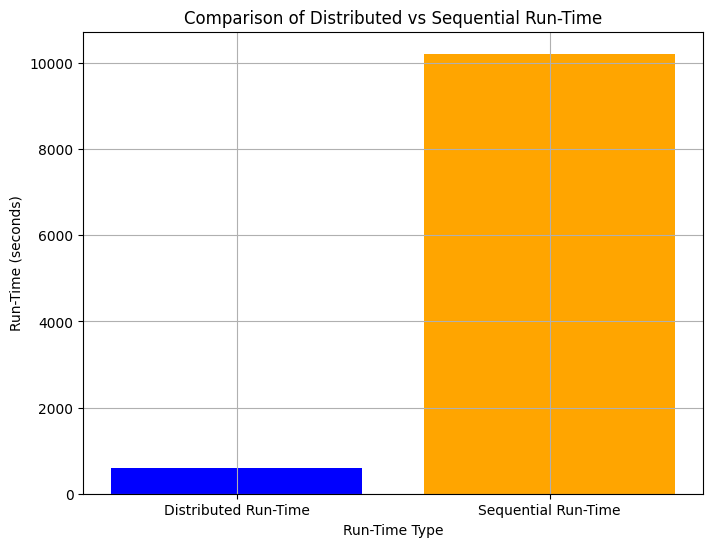

In [3]:
# Data
categories = ['Distributed Run-Time', 'Sequential Run-Time']
runtimes = [601.59, 10217.58]

# Create bar chart
plt.figure(figsize=(8, 6))
plt.bar(categories, runtimes, color=['blue', 'orange'])
plt.xlabel('Run-Time Type')
plt.ylabel('Run-Time (seconds)')
plt.title('Comparison of Distributed vs Sequential Run-Time')
plt.grid(True)

# Show plot
plt.show()